Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

If a variable is given to you, give your answer to that variable. In case of multiple choice questions, answer to the given variable. Make sure your variable has a **string value** and it contains only the letter of your choice. For example if you think that choice b is the correct choice, and the given variable is answer, your answer should look like this:

answer = 'b'

or 

answer = 'B'

If you need to read a file for a task, datafiles, such as .csv or .txt files are found in data subfolder. This can be accessed using data/filename.extension. In case of image, they are found in subfolder images. 

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name below:

In [1]:
NAME = "Houssem Menhour"

---

# Multimodal Data Fusion - Exercise 6 - Bayesian Decision Theory and Ensemble Learning


In this exercise, we will take a closer look at the Bayesian decision theory in pattern classification and in particular naive Bayes classification as a background and then represent ensemble learning.

## Learning goals 

After this exercise, you should  

- be able to apply naive Bayes classifier to typical classification problems
- be able to apply ensemble method such as bagging and boosting to combine hypotheses
- be able combine classifier output with different approaches for data fusion

## Relevant lecture
Lecture 7.
  
## Relevant Sections in course book

Chapter 13-14.

## Additional Material 

Naive Bayes: https://scikit-learn.org/stable/modules/naive_bayes.html

Adaboost:  https://scikit-learn.org/stable/modules/ensemble.html#adaboost

Support vector machines:  https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47 and  https://scikit-learn.org/stable/modules/svm.html 

Bagging: https://scikit-learn.org/stable/modules/ensemble.html#bagging-meta-estimator


# Introduction

In this exercise, the followig base classifiers are used: Naive Bayes, Adaboost and Support vector machines. In addition, bagging ensemble method is applied.

You can find info about the classifiers and their usage from the course book and the additional material.

# 1. Bayesian decision theory

## Tutorial

<div class=" alert alert-info">
We consider a dataset containing information about animal species. From the full dataset certain columns are selected for classification problem. A separate training set is extracted and summary of it is printed. 

</div>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/zoo/zoo.data", delimiter=",", header=None)
data2 = pd.read_csv("data/zoo2.csv", delimiter=",", header=0)
data3 = pd.read_csv("data/zoo3.csv", delimiter=",", header=0)


print(data.head())

#Remove animal names from the data (= first column).
data = data.iloc[:,1:18]
data2 = data2.iloc[:,1:18]
data3 = data3.iloc[:,1:18]

#Add column names.legs
data.columns = ["hair", "feathers","eggs","milk","airborne","aquatic","predator","toothed","backbone","breathes","venomous",
                "fins","legs","tail","domestic","catsize","class_type"]

data = data.append(data2, ignore_index=True)
data = data.append(data3, ignore_index=True)

data = data.astype('category')


#Select training data X and training labels y
#Let's select columns legs and airborn and classes 1 and 2 (mammals and birds)

X = data.loc[(data["class_type"]==2) | (data["class_type"]==1), ["legs", "airborne"]]
y = data.loc[(data["class_type"]==2) | (data["class_type"]==1), ["class_type"]]

#Look basic info about the data selected.
print(X.describe())
print(y.describe())

         0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  \
0  aardvark   1   0   0   1   0   0   1   1   1   1   0   0   4   0   0   1   
1  antelope   1   0   0   1   0   0   0   1   1   1   0   0   4   1   0   1   
2      bass   0   0   1   0   0   1   1   1   1   0   0   1   0   1   0   0   
3      bear   1   0   0   1   0   0   1   1   1   1   0   0   4   0   0   1   
4      boar   1   0   0   1   0   0   1   1   1   1   0   0   4   1   0   1   

   17  
0   1  
1   1  
2   4  
3   1  
4   1  
        legs  airborne
count    100       100
unique     3         2
top        2         0
freq      48        65
        class_type
count          100
unique           2
top              1
freq            60


/tmp/ipykernel_239272/895656088.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data2, ignore_index=True)
/tmp/ipykernel_239272/895656088.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data3, ignore_index=True)


<div class=" alert alert-info">    
Below we continue to process the data and plot it so that marker size presents the number of samples fulfilling the conditions presented by x and y axis. 

</div>

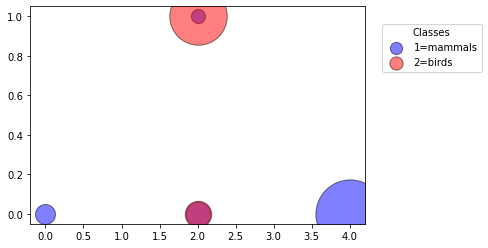

In [3]:
#Change the format into numpy-array as that format is needed further instead of dataframe.
X = np.array(X)
y = np.array(y)

#Do a scatter plot of values.

fig, ax = plt.subplots()

x_legs = [0,2,4]
y_air = [0,1]
groups = [1,2]
colors = ["blue", "red"]

#Adjust marker size according to number of samples 

for group in groups:
    subX = X[np.where(y==group)[0],:]

    for x in x_legs:
        subsubX = subX[np.where(subX[:,[0]]==x)[0],1]

        for s in y_air:
            marker_size = len(np.where(subsubX==s)[0])
            scatter = ax.scatter(x, s, marker='o',c=colors[group-1],
                s=marker_size*100, edgecolor='k', alpha=0.5, label=group)

#Get legend handles and select only one handle from each group.
handles,labels = ax.get_legend_handles_labels()
legend = ax.legend((handles[2], handles[8]),('1=mammals', '2=birds'), loc = [1.05, 0.7], title = "Classes", markerscale=0.5)   

plt.show()

<div class=" alert alert-info">  
We also create an NaiveBayes classifier and train it. A prediction for a test point [2,0] (two-legged animals which cannot fly) is calculated and its posterior probabilites.
    
</div>

In [4]:
from sklearn.naive_bayes import CategoricalNB
#Create Categorical Naive Bayes object
cnb = CategoricalNB()

#Fit model with X and y. np.ravel() is used for shaping y from column vector into 1D-array format.
cnb = cnb.fit(X,np.ravel(y))

#Predict the class for a sample point (2,0).
sample = [2,0]
predClass = cnb.predict([sample])[0]

#Posterior probabilities that sample [2,0] belongs to class 1 and class 2.
prob = cnb.predict_proba([sample])

#Print class.
print("The predicted class for a point",sample,"is", predClass)
print("The probability that the point belongs to class 1 is", prob[0,0])
print("The probability that the point belongs to class 2 is", prob[0,1])

The predicted class for a point [2, 0] is 1
The probability that the point belongs to class 1 is 5.324602746509388e-01
The probability that the point belongs to class 2 is 0.46753972534906135


The classifier predicts that the sample is a mammal.

## Problems

<div class=" alert alert-warning"> 
    <b>Problem 1.1.</b> 
    
Look basic info of both groups (birds and mammals) separately from the selected training data and answer to the following two questions.
    
1. How many mammals there is with two legs?
    
2. How many of them can fly and how many cannot?
    

</div>

In [5]:
# Answer by assigning a number (integer) to each variable. Use the dataset (variable data) to calculate each value

# YOUR CODE HERE

two_leg_mammals =  data.loc[(data["class_type"]==1) & (data["legs"]==2)].shape[0] # Number of MAMMALS with two legs
flying = data.loc[(data["class_type"]==1) & (data["legs"]==2) & (data["airborne"]==1)].shape[0] # Number of MAMMALS with two legs that can fly
not_flying = data.loc[(data["class_type"]==1) & (data["legs"]==2) & (data["airborne"]==0)].shape[0] # Number of MAMMALS with two legs that can not fly

In [6]:
# Your points for the Problem 1.1.1 will be given in this cell. Do not modify it.

In [7]:
# Your points for the Problem 1.1.2 will be given in this cell. Do not modify it.

<div class=" alert alert-warning"> 
    <b>Problem 1.2.</b> 
    
Answer the following questions.
    
1.Why animals with 2 legs and which cannot fly are classified as mammals although number of birds grouped as having two legs and unable to fly is bigger?
    
2.According to Wikipedia (https://en.wikipedia.org/wiki/Flightless_bird) there are 60 bird species that cannot fly. Unfortunately, no exact estimate of 2 legged mammals was found but if it is less than 60, what can you say about the performance of our model in real life? How could you improve our model with the data set given? Do improvements and tell what are the probabilities now? HINT: check parameters of CategoricalNB().

</div>

Answer to question 1.2.1 in the cell below

The number of mammal samples is higher than the number of birds, and that skews the probabilities in favor of the mammal class regardless of the other features.

In [8]:
# Problem 1.2.2 Do improvements

# YOUR CODE HERE

# Create Categorical Naive Bayes object, use fit_prior = False
cnb = CategoricalNB(fit_prior = False)
cnb = cnb.fit(X,np.ravel(y))
sample = [2,0]
predClass = cnb.predict([sample])[0]

probs = cnb.predict_proba([sample]) # Calculate the probabilities for both classes. The probs variable should contain a numpy array of size 2, with the lower probability first. 
# See tutorial for help
# Do prediction using point [[2,0]] (2 legs, cannot fly)

#print(predClass)
print(probs) # Check if output is as instructed

[[0.4315718 0.5684282]]


In [9]:
# Your points for the Problem 1.2 will be given in this cell. Do not modify it.

#### 1.2.2 what can you say about the performance of our model in real life? How could you improve our model with the data set given? Do improvements and tell what are the probabilities now? 

Answer to question 1.2.2 in the cell below

The previous model does not align with real life observations. To improve it, we can retrain it while ignoring the class prior in our data with `fit_prior = False`. This way, the model will assume uniform priors and fit the classifier based on the class features alone. The new model prediction probabilities are 0.43 for 'mammal' and 0.57 for 'bird'

# 2. Ensemble learning

## Tutorial

<div class=" alert alert-info">
In this part we familiarize ourselves with two ensemble methods called bagging and boosting.
</div>

### Bagging

<div class=" alert alert-info">
Below we use Gaussian Naive Bayes classifier as a weak classifier. Here we use Iris-dataset found from Scikit-learn's data sets. We train our model with different number of weak classifiers involved and see how it affects to our test results. Note the use of k-fold cross-validation from sklearn.
</div>

       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)  
count        150.000000  
mean           1.199333  
std            0.762238  
min            0.100000  
25%            0.300000  
50%            1.300000  
75%            1.800000  
max            2.500000  
count    150.000000
mean       1.000000
std        0.819232
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: target, dtype:

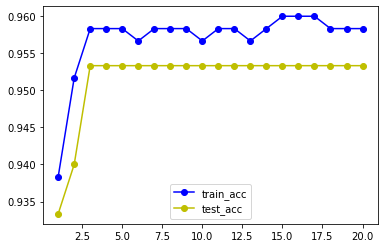

In [10]:
#import libraries
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedKFold

#Load Iris-dataset.
dataIris = load_iris(as_frame=True)
dataIris = dataIris.frame

#Separate train and test set.
X = dataIris.iloc[:,:4]
y = dataIris.iloc[:,4]

#Look basic info about the data selected.
print(X.describe())
print(y.describe())

#Transform to numpy array.
X = np.array(dataIris.iloc[:,:4])
y = np.ravel(np.array((dataIris.iloc[:,4])))

#Here cross-validation (stratified K-fold) is used.
skf = StratifiedKFold()

#Initialize variables to store the number of laps and an array for storing accuracy values.
learn_count = 0
learning = np.zeros([20,2])

#Test different number of weak classifiers from 1 to 20.
for n_estim in range(1,21,1):
    
    #Create BaggingClassifier() object.
    bc = BaggingClassifier(base_estimator=GaussianNB(), n_estimators= n_estim, random_state=0)
    
    count = 0
    accuracies = np.zeros([5,2])

    #Fit model and predict the outcome
    for train_index, test_index in skf.split(X, y):
        #print(train_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        #Fit it with X and y.
        bc.fit(X_train,y_train)

        #Calculate training and testing accuracies
        train_acc = bc.score(X_train, y_train)
        test_acc  = bc.score(X_test, y_test)
    
        accuracies[count,0] = train_acc
        accuracies[count,1] = test_acc
    
        count += 1
    
    #Calculate the mean of all folds
    mean_acc = np.mean(accuracies,axis=0)
   
    #save average means to final accuracy array.
    learning[learn_count,:] = mean_acc
    learn_count += 1

#Plot learning curve.
fig2,ax2 = plt.subplots()

ax2.plot(range(1,21,1),learning[:,0],'bo-', label = 'train_acc')
ax2.plot(range(1,21,1),learning[:,1],'yo-', label = 'test_acc')
legend = ax2.legend(loc='lower center')
plt.show()


### Boosting

<div class=" alert alert-info">
Here we repeat the same procedure with the same data set using Adaboost-classifier, which uses decision tree stumps as a weak classifier.
</div>

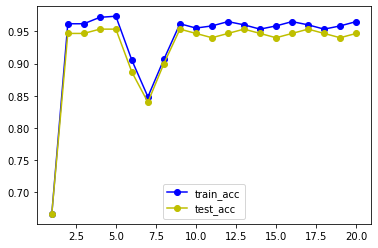

In [11]:
#import libraries
from sklearn.ensemble import AdaBoostClassifier

#Initialize variables to store the number of laps and an array for storing accuracy values.
learn_count = 0
learning = np.zeros([20,2])

#Test different number of weak classifiers from 1 to 20.
for n_estim in range(1,21,1):   
    
    #Create AdaBoosClassifier object.
    ada = AdaBoostClassifier(n_estimators=n_estim, random_state=0)

    count = 0
    accuracies = np.zeros([5,2])

    #Fit model and predict the outcome
    for train_index, test_index in skf.split(X, y):
    
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        #Fit it with X and y.
        ada.fit(X_train,y_train)

        #Calculate training and testing accuracies
        train_acc = ada.score(X_train, y_train)
        test_acc  = ada.score(X_test, y_test)
    
        accuracies[count,0] = train_acc
        accuracies[count,1] = test_acc
    
        count += 1
        
    mean_acc = np.mean(accuracies,axis=0)
    #print(np.mean(accuracies,axis=0))
    
    learning[learn_count,:] = mean_acc
    learn_count += 1  
    
fig3,ax3 = plt.subplots()

ax3.plot(range(1,21,1),learning[:,0],'bo-', label = 'train_acc')
ax3.plot(range(1,21,1),learning[:,1],'yo-', label = 'test_acc')
legend = ax3.legend(loc='lower center')
plt.show()

## Problems

<div class=" alert alert-warning"> 
    <b>Problem 2.1.</b> 

Experiment the behaviour of bagging and adaboost on an artificial data set. Plot learning curves as a function of studied parameter. In order to make comparison easier you can try to plot the training curves of both classifiers in one plot and the testing curves in another.
    
1. Test different number of samples in the training set (between 500 and 10000 with step size 1000).

2. How the different outcomes of classifiers can be explained?

You may also try other changes in data set. Like how increasing the number of features or number of informative features affects.

</div>

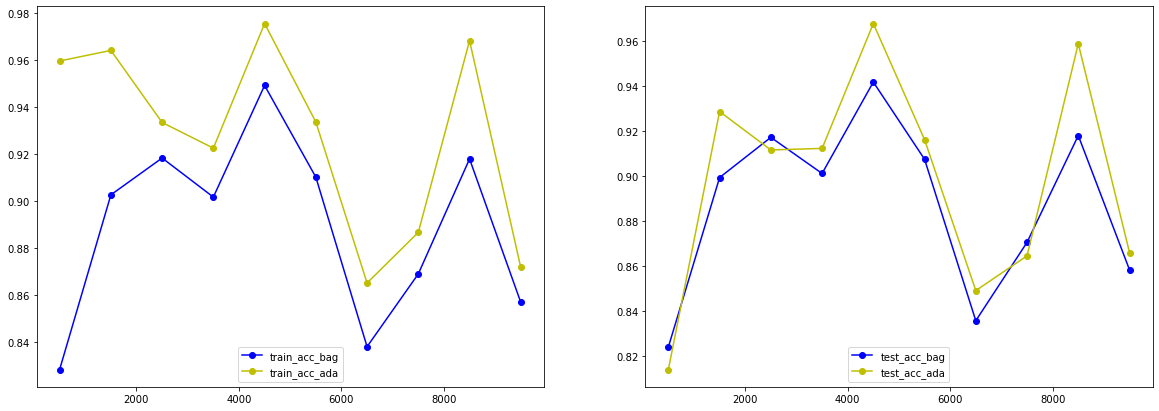

In [12]:
from sklearn.datasets import make_classification

#To create artificial data set use make_classification function with following parameters.

#X_art, y_art = make_classification(n_samples=changing number of samples, n_features=4,
                          # n_informative=2, n_redundant=0,
                           #random_state=0, shuffle=False)
        
#Use classifiers with following parameters:
#BaggingClassifier(base_estimator=GaussianNB(), n_estimators=100, random_state=0)
#AdaBoostClassifier(n_estimators=100, random_state=0)
#Use StratifiedKFold() as in the tutorial section.

learn_count = 0

learning_bag = np.zeros([10,2])
learning_ada = np.zeros([10,2])

#Add your code here.
#Use this loop as a base for your code
for nsamp in range(500,10000,1000): 
    #Create an artifical dataset of 'nsamp' samples with four features of which two are informative and divides points into two classes
    #See tutorials for help for the loop
    
    # YOUR CODE HERE
    X_art, y_art = make_classification(n_samples=nsamp, n_features=4, n_informative=2, n_redundant=0, random_state=0, shuffle=False)
    bc = BaggingClassifier(base_estimator=GaussianNB(), n_estimators=100, random_state=0)
    ada = AdaBoostClassifier(n_estimators=100, random_state=0)
    skf = StratifiedKFold()
    
    count = 0
    accuracies = np.zeros([5,4])

    #Fit model and predict the outcome
    for train_index, test_index in skf.split(X_art, y_art):
    
        X_train, X_test = X_art[train_index], X_art[test_index]
        y_train, y_test = y_art[train_index], y_art[test_index]
    
        bc.fit(X_train,y_train)
        ada.fit(X_train,y_train)

        #Calculate training and testing accuracies
        train_acc_bag = bc.score(X_train, y_train)
        test_acc_bag = bc.score(X_test, y_test)
        
        train_acc_ada = ada.score(X_train, y_train)
        test_acc_ada  = ada.score(X_test, y_test)
    
        accuracies[count,:2] = [train_acc_bag, test_acc_bag]
        accuracies[count,2:] = [train_acc_ada, test_acc_ada]
        
        count += 1
    
    mean_acc = np.mean(accuracies,axis=0)
    learning_bag[learn_count,:] = mean_acc[:2]
    learning_ada[learn_count,:] = mean_acc[2:]
    learn_count += 1  
    
    
#learning_bag = "Your answer here" # mean values for bagging accuracies

#learning_ada = "Your answer here" # mean values for adaboost accuracies

f = plt.figure(figsize=(20,7))
f.add_subplot(1,2,1)
plt.plot(range(500,10000,1000),learning_bag[:,0],'bo-', label = 'train_acc_bag')
plt.plot(range(500,10000,1000),learning_ada[:,0],'yo-', label = 'train_acc_ada')
plt.legend(loc='lower center')

f.add_subplot(1,2,2)
plt.plot(range(500,10000,1000),learning_bag[:,1],'bo-', label = 'test_acc_bag')
plt.plot(range(500,10000,1000),learning_ada[:,1],'yo-', label = 'test_acc_ada')
plt.legend(loc='lower center')

plt.show()

In [13]:
# Your points for the Problem 2.1 learning_bag will be given in this cell. Do not modify it.

In [14]:
# Your points for the Problem 2.1 learning_ada will be given in this cell. Do not modify it.

#### 2.1.2 How the different outcomes of classifiers can be explained?

Answer to question 2.1.2 in the cell below

Adaboost performs slightly better than bagging classifier overall, however the results vary significantly depending on the the number of samples, the hyper parameters of each classifier need to be fine tuned together with the number of samples.

# 3. Classifier combination strategies, diversity techniques

## Tutorial

<div class=" alert alert-info">
In this part we will use three different classifiers as base classifiers: Naive Bayes, Support Vector Machines and Adaboost. Below the needed classifier objects are created and fitted with training data. 
</div>

## Base classifiers

In [15]:
#import needed functions from libraries
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

#Create an artificial dataset of 1000 samples with 9 features of which 6 separates them into 3 different classes.
X, y = make_classification(n_samples=1200, n_features=9,
                           n_informative=6, n_redundant=0, 
                           n_classes=3,random_state=0, 
                           shuffle=False)


#Divide the data into training set and test set (the last sample of the whole data set).
#Each classifier will get its own subset of features.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X1 = X_train[:,0:3]
X2 = X_train[:,3:6]
X3 = X_train[:,6:9]

xtest1 = X_test[:,0:3]
xtest2 = X_test[:,3:6]
xtest3 = X_test[:,6:9]

#Create GaussianNB() classifier object and train it wirh train set X1
gnb = GaussianNB()
gnb = gnb.fit(X1, y_train)

#Create support vector machine classifier object SVC() with a parameter probability = True.
#and train it with train set X2.
svc = SVC(probability=True)
svc = svc.fit(X2, y_train)

#Create AdaBoostClassifier() object. Set parameters n_estimators=100 and random_state=0.
#and train it with train set X3
ada = AdaBoostClassifier(n_estimators=100, random_state=0)
ada = ada.fit(X3, y_train)

## Simple combination rules

<div class=" alert alert-info">
Below we combine the three trained classifiers by using different simple combinaton rules.
</div>

In [16]:
from sklearn.metrics import accuracy_score

### naive Bayes ###

#Predict class label for xtest1.
ypred1 = gnb.predict(xtest1)

#Calculate the probabilities for the sample to belong to each of three classes. 
yprob1 = gnb.predict_proba(xtest1)


### Support vector machine ###

#Predict class label for xtest2.
ypred2 = svc.predict(xtest2)

#Calculate the probabilities for the sample to belong to each of three classes.
yprob2 = svc.predict_proba(xtest2)

#Calculate confidence scores for the sample. (The distance from a decision boundary for each class.)
ybelief2 = svc.decision_function(xtest2)


### AdaBoost ###

#Predict class label for xtest3.
ypred3 = ada.predict(xtest3)

#Calculate the probabilities for the sample to belong to each of three classes.
yprob3 = ada.predict_proba(xtest3)

#Calculate confidence scores for the sample. (The weighted importance of base classifiers that predict the class in question.)
ybelief3 = ada.decision_function(xtest3)

#Calculate training accuracies for each classifier.
#GaussianNB
w1 = gnb.score(X1, y_train)

#Support vector classifier
w2 = svc.score(X2, y_train)

#Adaboost classifier
w3 = ada.score(X3, y_train)


#Create weight vector according to training accuracies.
weights = np.array((w1, w2, w3))

#Create labels matrix, in which one is marked according to the predicted label of each classifier.
labels = np.zeros((3, np.max(y_train)+1,len(y_test)))
for count in range(len(y_test)):
    labels[0, ypred1[count],count] = 1
    labels[1, ypred2[count],count] = 1
    labels[2, ypred3[count],count] = 1


#Create posterior scores array
posterior_scores = np.array((yprob1, yprob2, yprob3))

#Create measurement scores array
measurement_scores = np.array((yprob1, ybelief2, ybelief3))

#Create rank array of posterior scores.
rank = np.argsort(posterior_scores)

#Give scores according to rank positions.
rank_scores = np.zeros(rank.shape)

for classifier in range(3):
    for sample in range(len(y_test)):
        count = 0
        for classes in rank[classifier,sample]:#first class in a row gets the smallest score and last the highest score.
            rank_scores[classifier,sample,classes] = count + 1
            count +=1
            
#Weighted labels
weighted_labels = np.zeros(labels.shape)
for r in range(3):
    weighted_labels[r,:,:] = weights[r]*labels[r,:,:]

#Weighted posterior_scores
weighted_scores = np.zeros(posterior_scores.shape)
for r in range(3):
    weighted_scores[r,:,:] = weights[r]*posterior_scores[r,:,:]

#Calculate different combination metrics. 
test_acc = accuracy_score(y_test, np.argmax(np.sum(labels, axis=0),axis=0))
print('Majority vote: ',test_acc)

test_acc = accuracy_score(y_test, np.argmax(np.sum(rank_scores,axis=0),axis=1))
print('Borda count: ', test_acc)

test_acc =  accuracy_score(y_test, np.argmax(np.prod(posterior_scores,axis=0),axis=1))
print('Prod: ', test_acc)

test_acc = accuracy_score(y_test, np.argmax(np.mean(posterior_scores, axis=0),axis=1))
print('Mean: ', test_acc)

test_acc = accuracy_score(y_test, np.argmax(np.median(posterior_scores, axis=0),axis=1))
print('Median: ', test_acc)

test_acc = accuracy_score(y_test, np.argmax(np.max(posterior_scores, axis=0),axis=1))
print('Max: ', test_acc)

test_acc = accuracy_score(y_test, np.argmax(np.min(posterior_scores, axis=0),axis=1))
print('Min: ', test_acc)

test_acc = accuracy_score(y_test, np.argmax(np.sum(weighted_labels, axis=0),axis=0))
print('Weighted majority vote: ',test_acc)

test_acc = accuracy_score(y_test, np.argmax(np.mean(weighted_scores, axis=0),axis=1))
print('Weighted mean: ',test_acc)

test_acc = accuracy_score(y_test, np.argmax(np.mean(measurement_scores, axis=0),axis=1))
print('Belief mean: ',test_acc)


#Individual test accuracies for each classifier:
print('Classifier 1', accuracy_score(y_test,ypred1))
print('Classifier 2', accuracy_score(y_test,ypred2))
print('Classifier 3', accuracy_score(y_test,ypred3))

Majority vote:  6.416666666666667e-01
Borda count:  0.6125
Prod:  0.7416666666666667
Mean:  0.7333333333333333
Median:  0.6791666666666667
Max:  0.7333333333333333
Min:  0.7208333333333333
Weighted majority vote:  0.6916666666666667
Weighted mean:  0.7375
Belief mean:  0.7208333333333333
Classifier 1 0.5875
Classifier 2 0.7208333333333333
Classifier 3 0.30833333333333335


## Problems

<div class=" alert alert-warning"> 
    <b>Problem 3.1.</b> 

Answer to the questions below.
    
1.Compare the results of different combiners. What reasons may cause the differences between combiners? 

2.Calculate the Yule's Q for each of the three classifier pairs <p>
    <b>Hint:</b> See p. 25 on lecture 7 slides and additional material is available <a href="http://machine-learning.martinsewell.com/ensembles/KunchevaWhitaker2003.pdf">here</a>

</div>

Answer to question 3.1.1 in the cell below

Each classifier make predictions independently and has a different individual score. The combiners result in different results because some of them will give more weight to the classifiers with higher confidence while others might treat all of them equally even those with very bad initial accuracy.

In [17]:
# Implement your code to Problem 3.1.2 here
# Give the Yule's Q's in variables q12, q13 and q23
# Calculate the diversity to variable q_av

# Perform pair-wise comparison for classifiers. 

# YOUR CODE HERE
def yule_q(pred1, pred2, y):
    true_1 = pred1 == y
    true_2 = pred2 == y
    
    a = sum(true_1 == true_2)
    b = sum(true_1 == np.logical_not(true_2))
    c = sum(true_2 == np.logical_not(true_1))
    d = sum(np.logical_not(true_1) == np.logical_not(true_2))
    
    q = (a*d - b*c) / (a*d + b*c)
    return q
    

q12 = yule_q(ypred1, ypred2, y_test) # Classifiers 1 and 2

q13 = yule_q(ypred1, ypred3, y_test) # Classifiers 1 and 3

q23 = yule_q(ypred2, ypred3, y_test) # Classifiers 2 and 3

q_av = np.mean([q12, q13, q23]) # Average for Yule Q values q12, q13 and q23

In [18]:
# Your points for the Problem 3.1 Yule's Q for classifier 1 and 2 will be given in this cell. Do not modify it.

In [19]:
# Your points for the Problem 3.1 Yule's Q for classifier 1 and 3 will be given in this cell. Do not modify it.

In [20]:
# Your points for the Problem 3.1 Yule's Q for classifier 2 and 3 will be given in this cell. Do not modify it.

In [21]:
# Your points for the Problem 3.1 average Yule's Q values will be given in this cell. Do not modify it.

## Meta-learners

<div class=" alert alert-warning"> 
    <b>Problem 3.2.</b> 
    

Train support vector meta classifier using the same data set and the same base classifiers. What is its accuracy?
<b>Use the same test set for testing as in the previous part.</b>
</div>

In [22]:
#Help:
#Here you need three separate data sets.
# One for training base classifiers.
# Second for creating training set for metaclassifier. (The probabilities of base classifiers' predictions in this new data.)
# Third for testing the accuracy in unseen data.

#For doing the two first phases, you can use stratified K-fold and the same training set that was created in previous part.
#For the last phase, use the same test set as in previous part.

#To combine probabilities of the three classifiers in one set you can use command: np.concatenate((xp1, xp2, xp3), axis=1)
#Where xp1 = the probabilities of classifier 1, xp2 = the probabilities of classifier 2, etc.


### Meta-learning with svm ###

#Initialize Support vector classifier without any input parmeters. This will be our Meta-classifier.
svc_meta = SVC() 

#Do K=5 stratified K-fold crossvalidation for training classifier.   
skf = StratifiedKFold()

# YOUR CODE HERE
for train_index, test_index in skf.split(X_train, y_train):
    X_train_f, X_test_f = X_train[train_index], X_train[test_index]
    y_train_f, y_test_f = y_train[train_index], y_train[test_index]
    
    X1_f = X_train_f[:,0:3]
    X2_f = X_train_f[:,3:6]
    X3_f = X_train_f[:,6:9]

    xtest1_f = X_test_f[:,0:3]
    xtest2_f = X_test_f[:,3:6]
    xtest3_f = X_test_f[:,6:9]
    
    gnb.fit(X1_f, y_train_f)
    xp1 = gnb.predict_proba(xtest1_f)
    
    svc.fit(X2_f, y_train_f)
    xp2 = svc.predict_proba(xtest2_f)
    
    ada.fit(X3_f, y_train_f)
    xp3 = ada.predict_proba(xtest3_f)
    
    probs = np.concatenate((xp1, xp2, xp3), axis=1)
    svc_meta.fit(probs, y_test_f)

yprobs1 = gnb.predict_proba(xtest1) # Calculate probabilities using gnb model

np.random.seed(0) # Do not remove or change!
yprobs2 = svc.predict_proba(xtest2) # Calculate probabilities using svc model

yprobs3 = ada.predict_proba(xtest3) # Calculate probabilities using adaboost model 

# Predict classes with the meta-classifier
predClass = svc_meta.predict(np.concatenate((yprobs1, yprobs2, yprobs3), axis=1)) # Combine probabilities and predict classes with trained svc

np.random.seed(0) #Do not change or remove
test_acc = accuracy_score(y_test, predClass) # Calculate accuracy for prediction using combined probabilities

In [23]:
# Your points for the Problem 3.2 test_acc will be given in this cell. Do not modify it.

In [24]:
# Your points for the Problem 3.2 yprob1 will be given in this cell. Do not modify it.

In [25]:
# Your points for the Problem 3.2 yprob2 will be given in this cell. Do not modify it.

In [26]:
# Your points for the Problem 3.2 yprob3 will be given in this cell. Do not modify it.

In [27]:
# Your points for the Problem 3.2 predClass will be given in this cell. Do not modify it.